In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
%matplotlib notebook
from Reinforcement_Learning import *
from Maze import *
from DrawMaze import *
import time
import matplotlib.pyplot as plt
from matplotlib import animation

In [2]:
#迷路生成
PATH = 0 #道
WALL = 1 #壁
STR = 'S' #スタート
GOL = 'G' #ゴール
mWidth, mHeight = 20, 20
maze = Maze(mWidth, mHeight)
maze.set_out_wall()
maze.set_inner_wall_botaoshi()
maze.set_start_goal()
maze.print_maze()
mWidth, mHeight = maze.get_width_height()
# 迷路データ maze.maze[x][y]

＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
＃Ｓ＃　　　　　＃　　　＃　　　　　　　＃
＃　＃　＃＃＃　＃　＃　＃　＃　＃＃＃　＃
＃　＃　＃　＃　　　＃　　　＃　＃　＃　＃
＃　＃　＃　＃＃＃　＃＃＃　＃＃＃　＃＃＃
＃　　　＃　＃　＃　　　＃　　　　　＃　＃
＃＃＃　＃　＃　＃　＃＃＃＃＃　＃＃＃　＃
＃　　　　　＃　＃　　　　　＃　　　　　＃
＃　＃　＃　＃　＃　＃＃＃＃＃　＃＃＃＃＃
＃　＃　＃　　　＃　　　　　＃　　　　　＃
＃　＃＃＃　＃＃＃＃＃　＃　＃　＃　＃　＃
＃　＃　＃　　　＃　＃　＃　＃　＃　＃　＃
＃　＃　＃＃＃　＃　＃　＃　＃＃＃＃＃　＃
＃　　　　　＃　＃　＃　＃　　　＃　＃　＃
＃　＃　＃　＃　＃　＃＃＃　＃　＃　＃＃＃
＃　＃　＃　＃　　　　　＃　＃　　　＃　＃
＃＃＃　＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃　＃
＃　　　　　＃　　　　　　　　　＃　　　＃
＃＃＃　＃　＃　＃＃＃＃＃　＃＃＃　＃＃＃
＃　　　＃　　　　　　　＃　　　　　　Ｇ＃
＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃


In [3]:
# 強化学習
# q値更新
learningRate = 0.1 #学習係数α
discountRate = 0.9 #割引率γ
qUpdate = QLearning(learningRate, discountRate) # Q学習

#行動選択方法
ep = 0.3 #ε
actionSelect = EpGreedy(ep) #ε-greedy 

learning = ReinforcementLearning(mWidth, mHeight, qUpdate, actionSelect)

In [4]:
#壁でないか確認
def is_not_wall(x, y):
    if maze.maze[x][y] == WALL:
        return False
    else:
        return True

In [5]:
# 迷路描画機能
imgW = 800
imgH = 800
draw = DrawMaze(imgW, imgH, maze.maze)

In [6]:
# 学習初期化
str_x, str_y = maze.get_start() #TODO Start位置の取得関数
gol_x, gol_y = maze.get_goal() #TODO Goal位置の取得関数
gol_reward = 30 #成功報酬
sx, sy = str_x, str_y
maxAction = 200 # 最大行動数
maxResetAction = (mWidth + mHeight) * 3 # リセットになる行動回数
resetAction = 0

In [7]:
for t in range(0, maxAction):
    # 次の行動を決定
    while True:
        nx, ny, action = learning.get_next_state(sx, sy)
        # 今回は次の行動が壁の時はキャンセルする
        if is_not_wall(nx, ny):
            break
    # Q値更新
    sq = learning.get_q_val(sx, sy, action)
    na, nq = learning.get_q_max_val(nx, ny)
    reward = gol_reward if (nx == gol_x and ny == gol_y) else 0
    p = [sq, nq, reward]
    learning.update_q_val(sx, sy, action, p)
    
    # 迷路描画
    draw.drawMaze(learning, gol_reward, sx, sy, nx, ny)
    sx, sy = nx, ny

In [11]:
#結果出力
for i in range(maxAction):
    im = Image.open('output/images/img_' + str(i)+ '.jpg') 
    plt.imshow(im)
    plt.pause(1)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


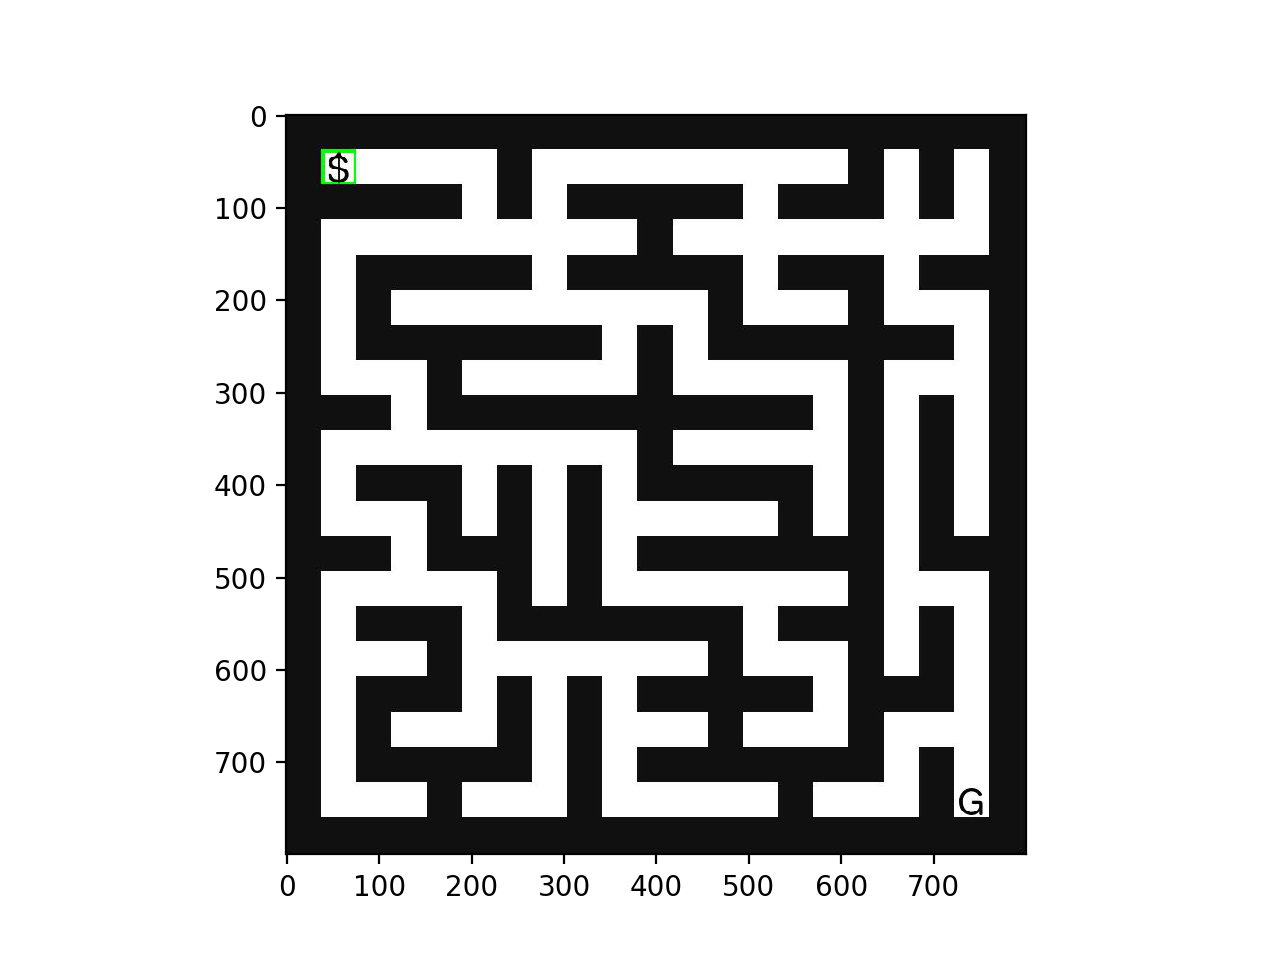

In [10]:
im = Image.open('output/images/img_0.jpg') 
plt.imshow(im)

In [ ]:
ima